In [14]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import numpy as np
import tensorflow as tf
from dsn.util.systems import V1Circuit
from dsn.train_dsn import train_dsn
from dsn.util.plot_util import assess_constraints, pairplot
import seaborn as sns
import pandas as pd
import warnings
import scipy
import time
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# set fixed params
fixed_params = {'W_EE':1.0, \
                'W_PE':1.0, \
                'W_SE':1.0, \
                'W_VE':1.0, \
                'h_FFE':0.0, \
                'h_FFP':0.0, \
                'h_LATE':0.0, \
                'h_LATP':0.0, \
                'h_LATS':0.0, \
                'h_LATV':0.0, \
                'tau':1.0, \
                'n':2.0, \
                's_0':30}

# set behavior
diff_inds = [0, 1, 2, 3]
c_vals=np.array([0.0])
s_vals=np.array([1.0])
r_vals=np.array([0.0, 1.0])
d_mean = np.array([1.0, 0.25, 1.0, 0.0]);
d_vars = np.array([0.01, 0.01, 0.01, 0.01]);
behavior = {'type':'difference', \
            'diff_inds':diff_inds, \
            'c_vals':c_vals, \
            's_vals':s_vals, \
            'r_vals':r_vals, \
            'd_mean':d_mean, \
            'd_var':d_vars}

# set model options
model_opts = {'g_FF':'c', 'g_LAT':'linear', 'g_RUN':'r'}

T = 40
dt = 0.25
init_conds = np.expand_dims(np.array([1.0, 1.1, 1.2, 1.3]), 1)

system = V1Circuit(fixed_params, behavior, model_opts=model_opts, \
                   T=T, dt=dt, init_conds=init_conds)

In [3]:
sample_str = 'grid';

if (sample_str == 'grid'):
    # create test parameter grid
    bound = 1.0
    start = 0.0;
    stop = bound;
    res = 0.5
    eps = .001*res;
    vals = np.arange(start, stop+eps, res);
    num_pts = vals.shape[0];

    total_pts = num_pts**8;
    params = np.zeros((total_pts,8));
    ind = 0;
    for i in range(num_pts):
        h_E1 = vals[i];
        for j in range(num_pts):
            h_P1 = vals[j];
            for k in range(num_pts):
                h_S1 = vals[k];
                for l in range(num_pts):
                    h_V1 = vals[l];
                    for ii in range(num_pts):
                        h_E2 = vals[ii];
                        for jj in range(num_pts):
                            h_P2 = vals[jj];
                            for kk in range(num_pts):
                                h_S2 = vals[kk];
                                for ll in range(num_pts):
                                    h_V2 = vals[ll];
                                    params[ind,:] = np.array([h_E1, h_P1, h_S1, h_V1, \
                                                              h_E2, h_P2, h_S2, h_V2]);
                                    ind += 1;
    print(params.shape);
    
elif (sample_str == 'file'):
    nlayers = 10;
    sigma_init = 1.0;
    c_init = -4;
    rs = 4;
        
    savedir = basedir + system_dir + '/' \
      'V1_circuit_D=8_flow=M_%dP_sigma=%.2f_lr_order=-3_c=%d_rs=%d/' % \
      (nlayers, sigma_init, c_init, rs);
    fname = savedir + 'results.npz';
    alpha = 0.05;
    npzfile = np.load(fname);
    phis = npzfile['phis'];
    T_phis = npzfile['T_phis'];
    n_suff_stat_train = T_phis.shape[2];
    mu = npzfile['mu'];
    k_max = phis.shape[0]-1;
    p_values, AL_final_its = assess_constraints([fname], alpha, k_max, mu, n_suff_stat_train);
    
    AL_final_it = AL_final_its[0];
    print(AL_final_it, phis.shape)
    params = phis[AL_final_it,:,:];
    print(params.shape);
    total_pts = params.shape[0];

else: # random
    total_pts = 10000;
    params = np.zeros((total_pts,8));
    x = np.random.normal(0,1.0,(total_pts,8));
    params = np.log(1+np.exp(x));

(6561, 8)


In [4]:
num_params = system.D;
K = 1;
Z = tf.placeholder(dtype=tf.float64, shape=(K, None, num_params));

sess = tf.Session()
T_x = system.simulation_suff_stats(Z);
_Z = np.expand_dims(params, 0);

In [5]:
nsamps = params.shape[0]

_T_x = sess.run(T_x, {Z:_Z});


In [6]:
for i in range(system.num_suff_stats):
    Txs = _T_x[0,:,i];

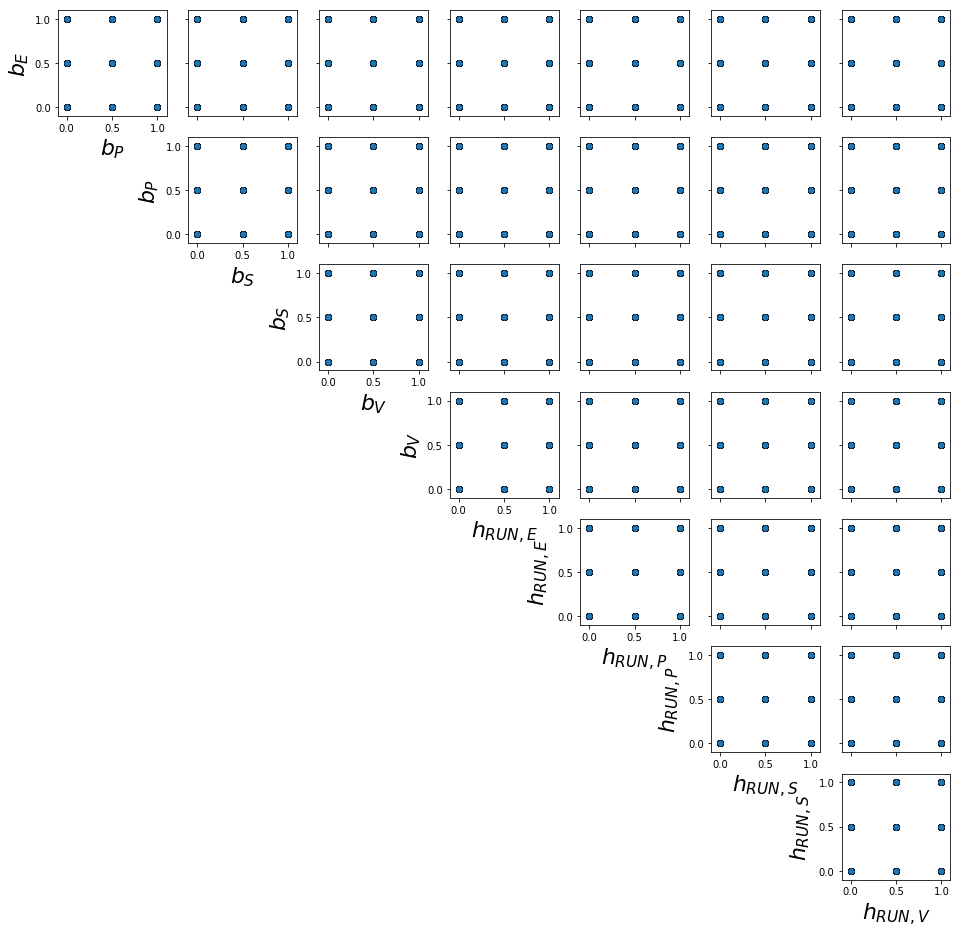

In [7]:
pfname = 'images/V1_grid_search_Z.png'
lims = [-.1, 1.1]
ticks = [0.0, 0.5, 1.0]
jitter = np.random.normal(0.0, 0.00, _Z.shape)
_Z_plot = (_Z + jitter)[0,:,:]

fig = pairplot(_Z_plot, range(8), system.z_labels, origin=False, \
                       c=None, c_label=None, cmap=None, \
                       xlims=lims, ylims=lims, ticks=ticks, fontsize=22, \
                       figsize=(16,16), pfname=pfname)

0.024179641367952427 0.41027557626010586


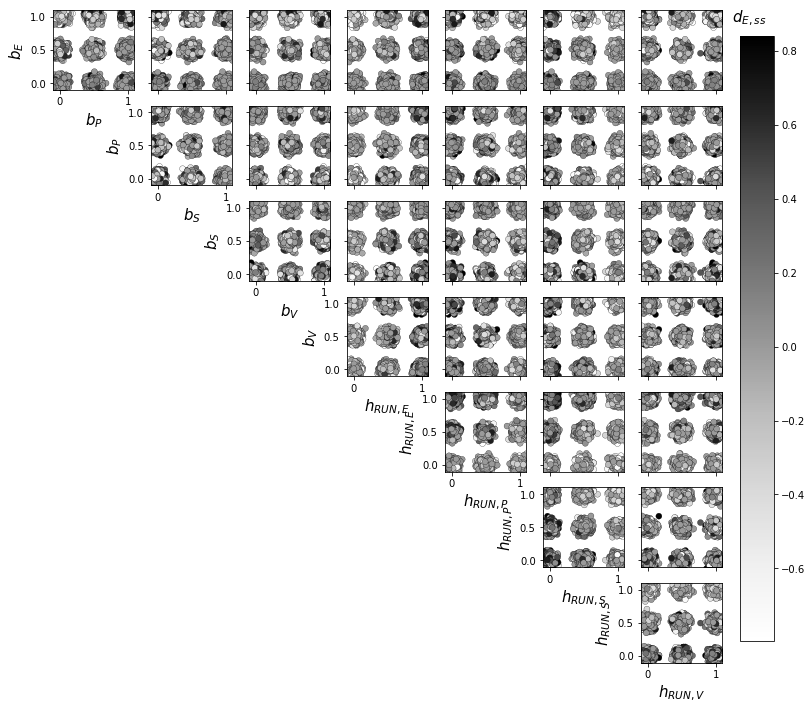

0.12943971993440603 0.27552720102558376


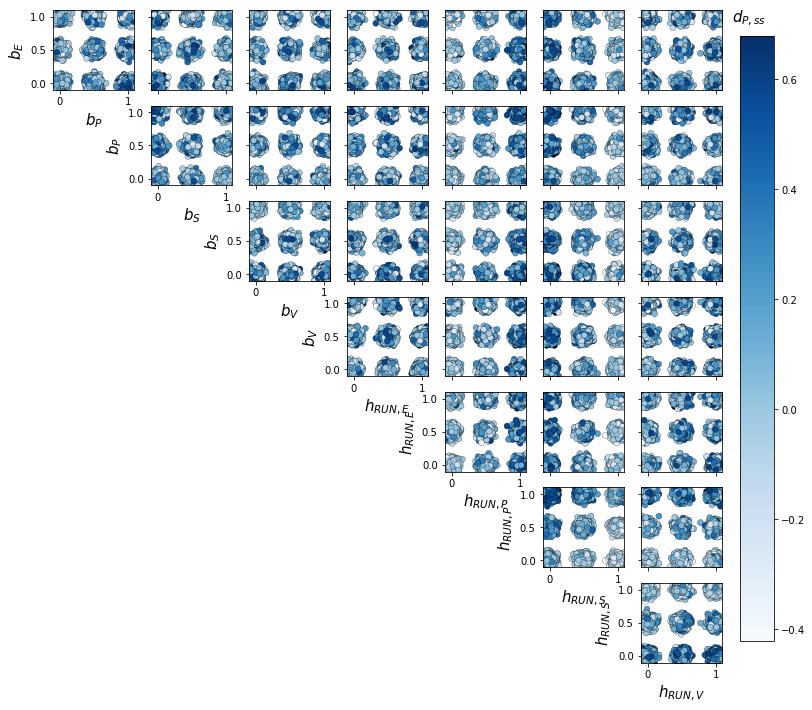

1.0676770922497116 1.0090574552541454


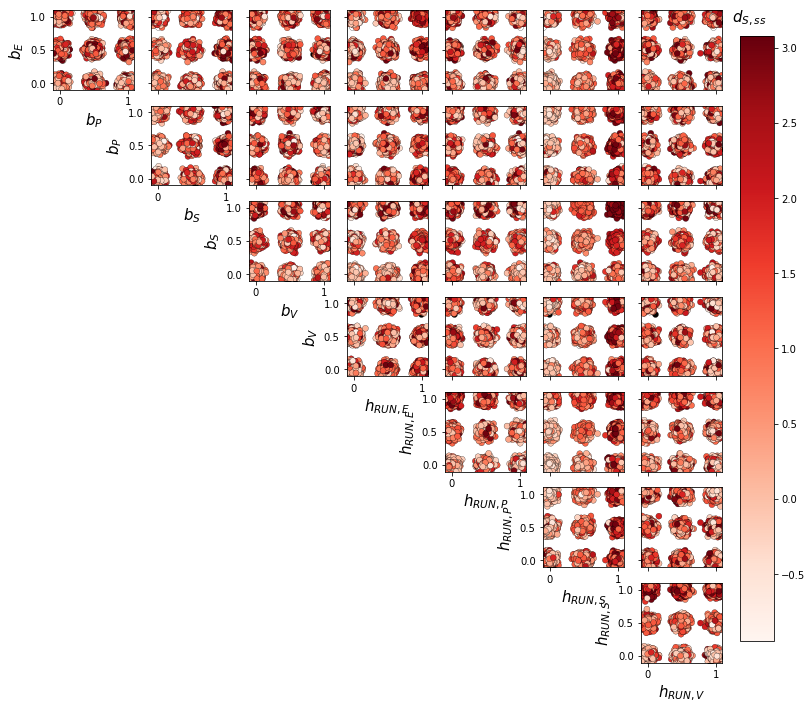

0.24877446258496047 1.3712746139546261


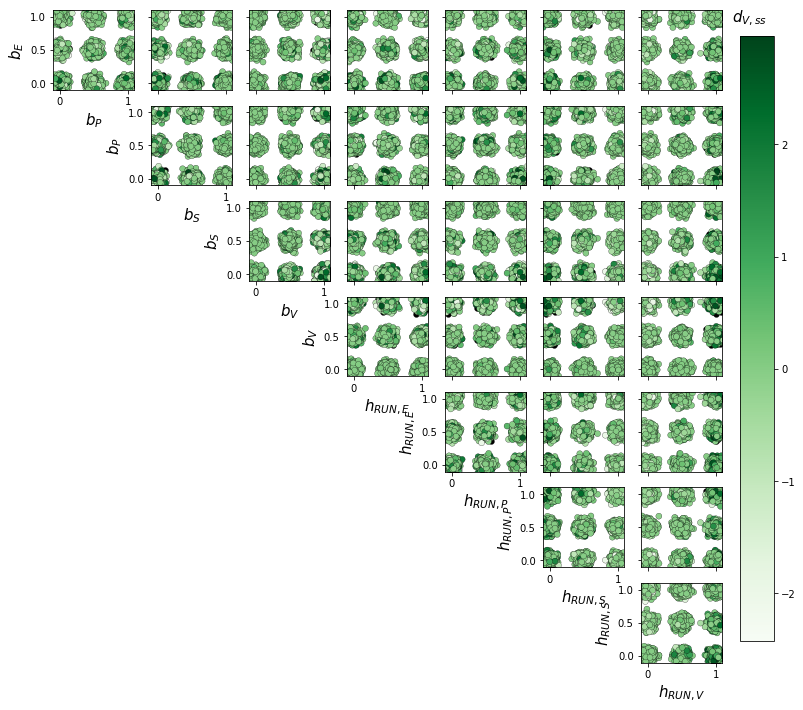

In [8]:
cmaps = [plt.cm.get_cmap('Greys'), plt.cm.get_cmap('Blues'), \
         plt.cm.get_cmap('Reds'), plt.cm.get_cmap('Greens')]
cstrs = ['dE', 'dP', 'dS', 'dV']
lims = [-.1, 1.1]
jitter = np.random.normal(0.0, 0.05, _Z.shape)
_Z_plot = (_Z + jitter)[0,:,:]
for color_ind in range(4):
    pfname = 'images/V1_grid_search_Z_%s.png' % cstrs[color_ind]
    fig = pairplot(_Z_plot, range(8), system.z_labels, origin=False, \
                       c=_T_x[0,:,color_ind], c_label=system.T_x_labels[color_ind], cmap=cmaps[color_ind], \
                       xlims=lims, ylims=lims, fontsize=15, \
                       figsize=(12,12), pfname=pfname)
    
    

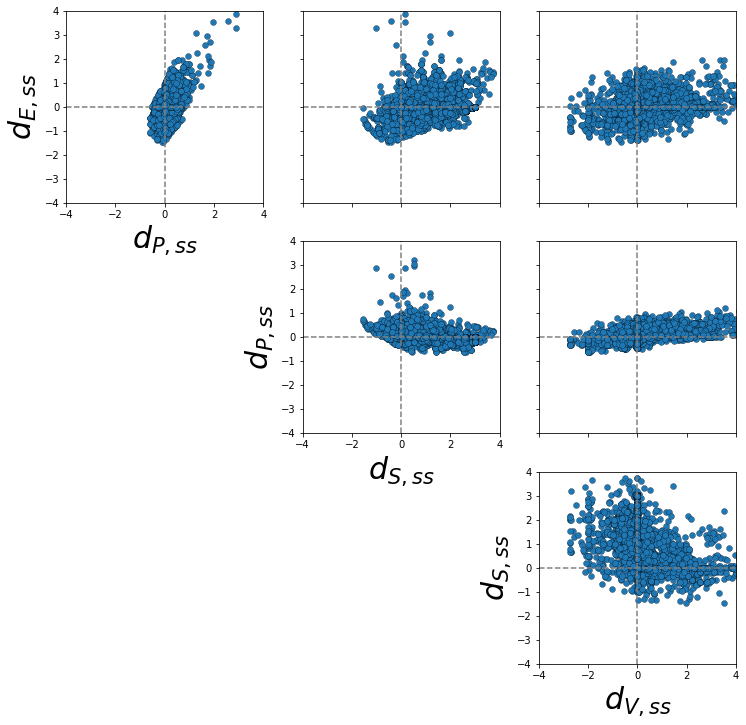

In [9]:
pfname = 'images/V1_grid_search_T_xs.png'
axlim = 4
xlims = [-axlim, axlim]
ylims = [-axlim, axlim]

fig = pairplot(_T_x[0], range(4), system.T_x_labels, origin=True, \
               c=None, c_label=None, cmap=None, \
               xlims=xlims, ylims=ylims, fontsize=30, \
               figsize=(12,12), pfname=pfname)


0.024179641367952427 0.41027557626010586


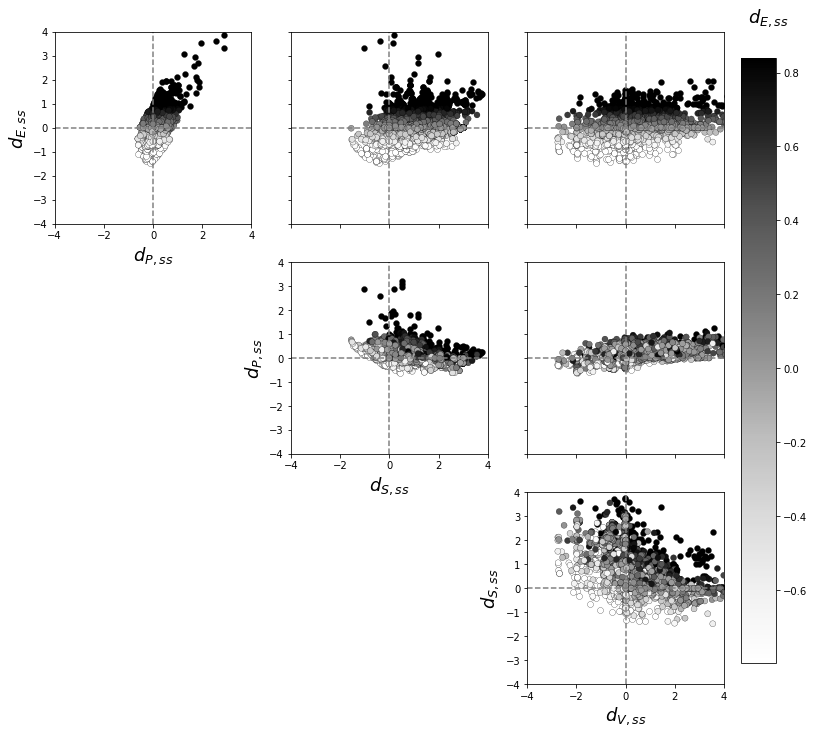

0.129439719934406 0.27552720102558376


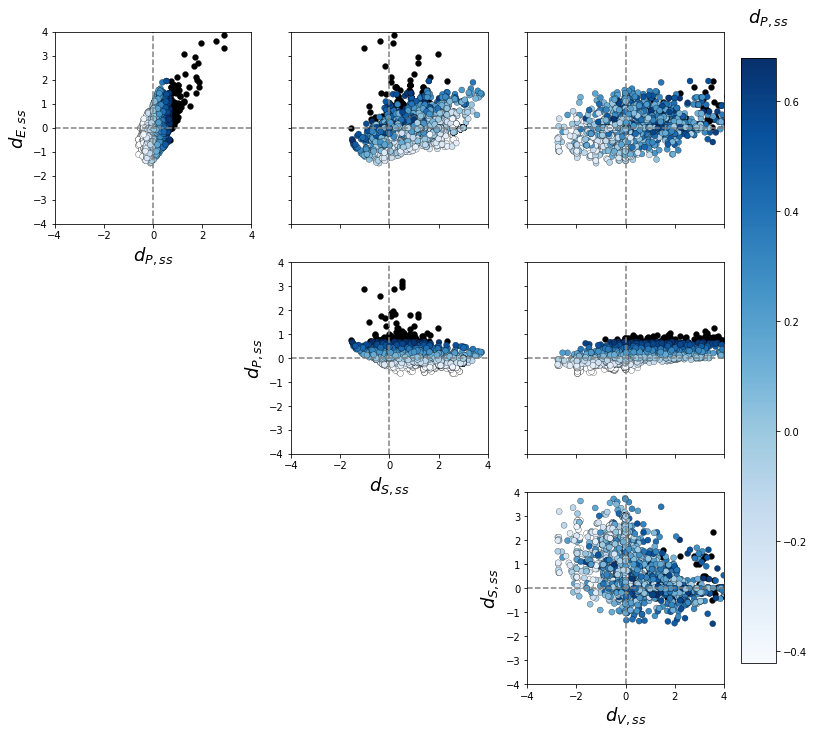

1.0676770922497116 1.0090574552541454


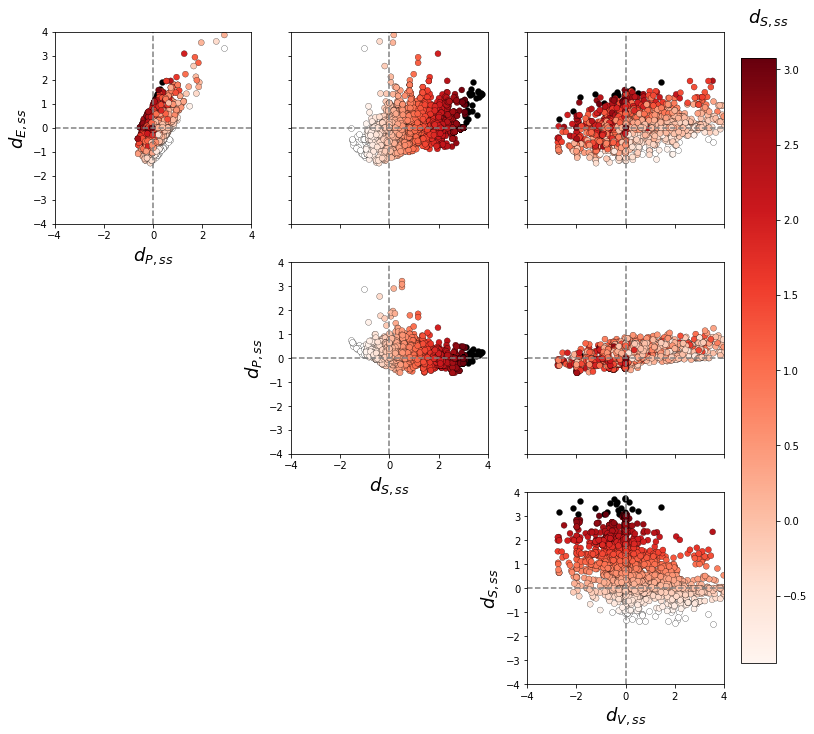

0.24877446258496047 1.3712746139546261


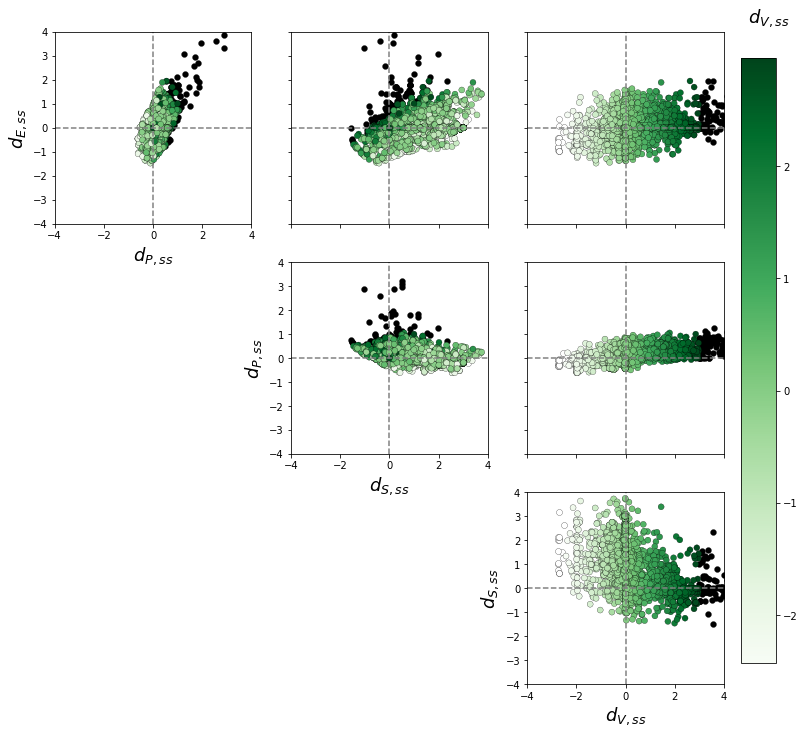

In [10]:
axlim = 4
xlims = [-axlim, axlim]
ylims = [-axlim, axlim]

figs = []
for color_ind in range(4):
    pfname = 'images/V1_grid_search_T_xs_%s.png' % cstrs[color_ind]
    fig = pairplot(_T_x[0], range(4), system.T_x_labels, origin=True, \
                   c=_T_x[0,:,color_ind], c_label=system.T_x_labels[color_ind], cmap=cmaps[color_ind], \
                   xlims=xlims, ylims=ylims, fontsize=18, \
                   figsize=(12,12), pfname=pfname)
    figs.append(fig)
 

0.13387174554857878 0.38838630892005904


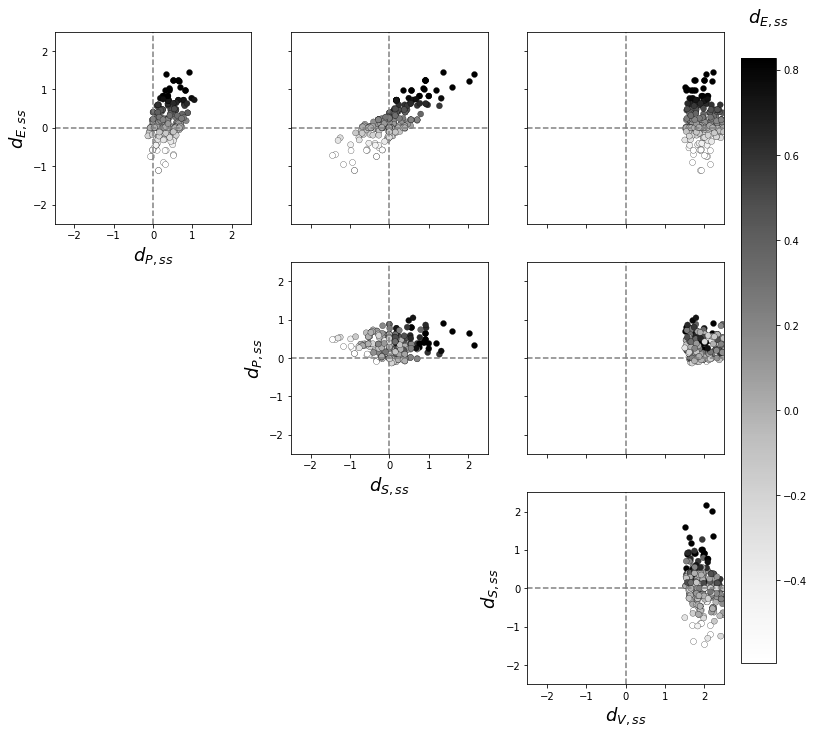

0.32388092723238016 0.24648021917943058


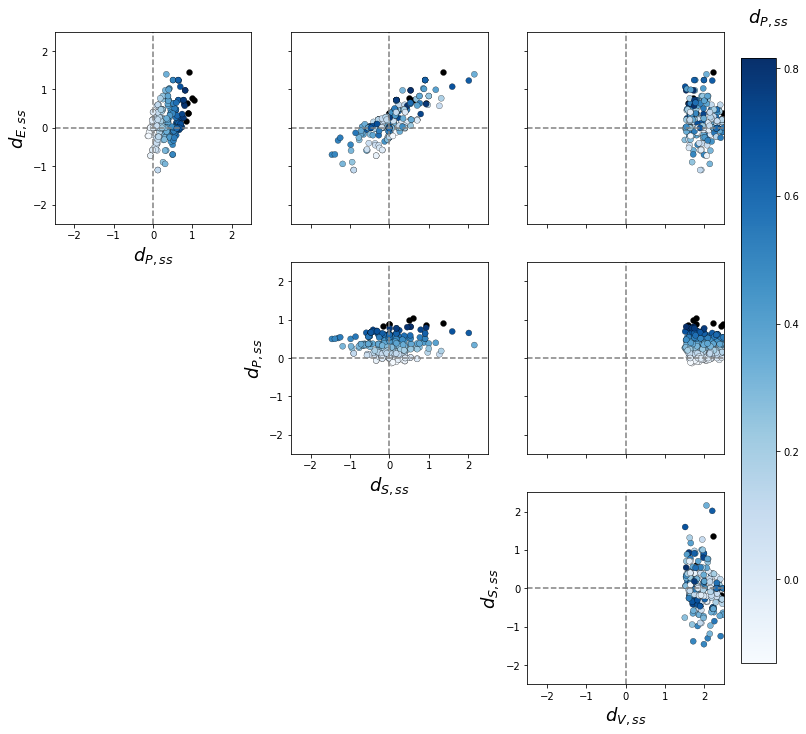

0.04168048275772261 0.47901243076468136


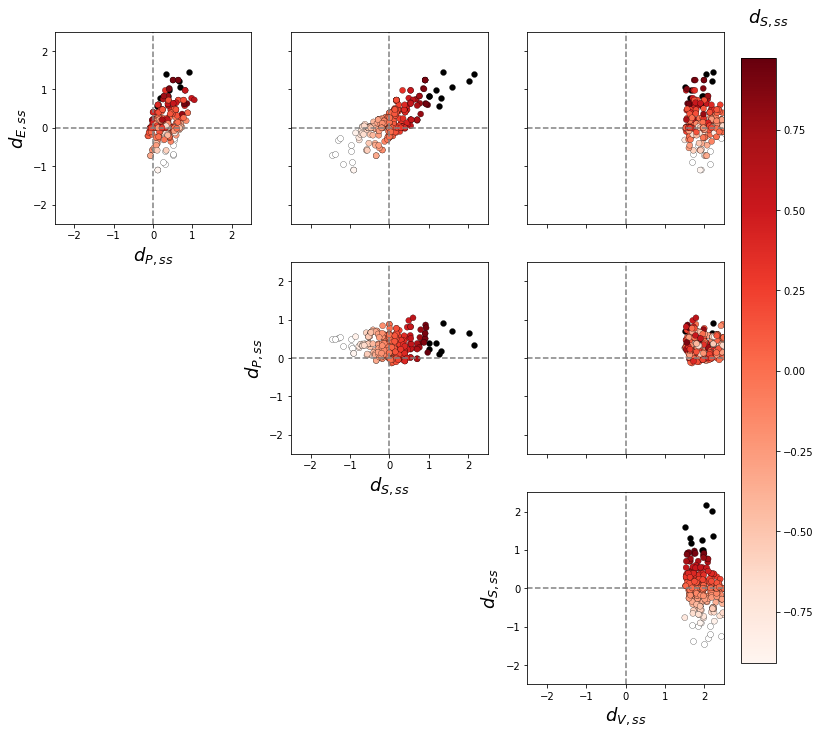

1.9305174302552475 0.2670479832166786


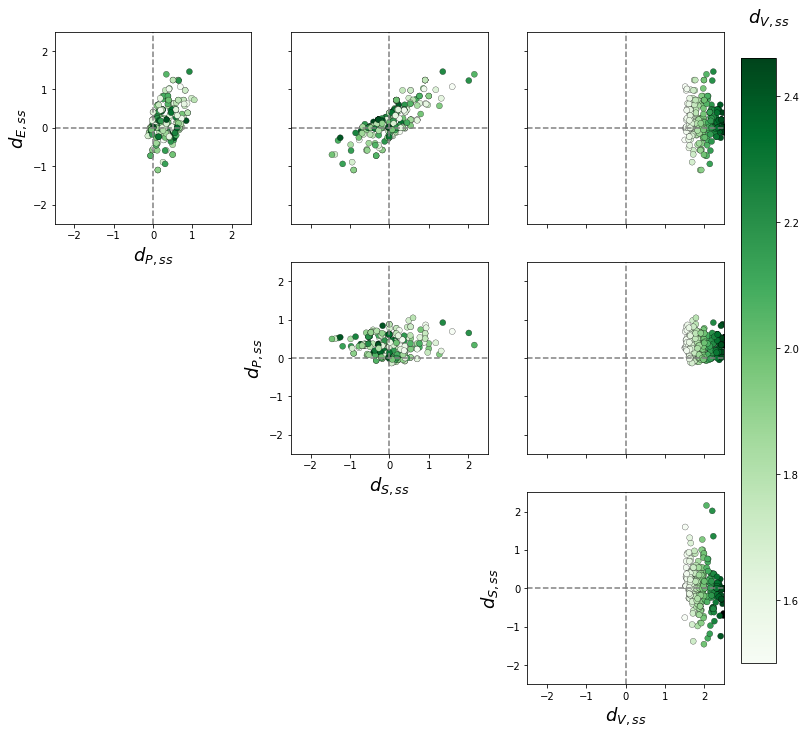

In [15]:
axlim = 2.5
xlims = [-axlim, axlim]
ylims = [-axlim, axlim]

#S_inc = np.logical_and(0.25 < _T_x[0,:,2], _T_x[0,:,2] < 0.75);
V_inc = np.logical_and(1.5 < _T_x[0,:,3], _T_x[0,:,3] < 2.5);
figs = []

for color_ind in range(4):
    fig = pairplot(_T_x[0, V_inc, :], range(4), system.T_x_labels, origin=True, \
                   c=_T_x[0,V_inc,color_ind], c_label=system.T_x_labels[color_ind], cmap=cmaps[color_ind], \
                   xlims=xlims, ylims=ylims, fontsize=18, \
                   figsize=(12,12), pfname='images/temp.png')
    figs.append(fig)
    
pdf = matplotlib.backends.backend_pdf.PdfPages("images/grid_samples_Vinc.pdf")
for fig in figs: ## will open an empty extra figure :(
    pdf.savefig(fig)
pdf.close()

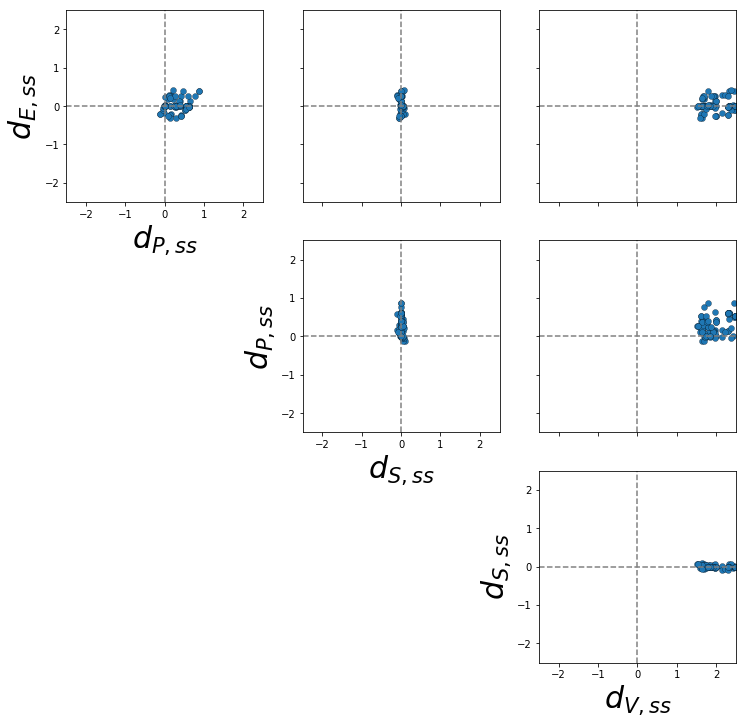

In [17]:
axlim = 2.5
xlims = [-axlim, axlim]
ylims = [-axlim, axlim]

S_same = np.logical_and(-0.1 < _T_x[0,:,2], _T_x[0,:,2] < 0.1);
S_same_V_inc = np.logical_and(S_same, V_inc);


fig = pairplot(_T_x[0,S_same_V_inc,:], range(4), system.T_x_labels, origin=True, \
               c=None, c_label=None, cmap=None, \
               xlims=xlims, ylims=ylims, fontsize=30, \
               figsize=(12,12), pfname='images/V1_grid_search_T_xs_thresh.png')


0.023806052200071405 0.16633462020060447


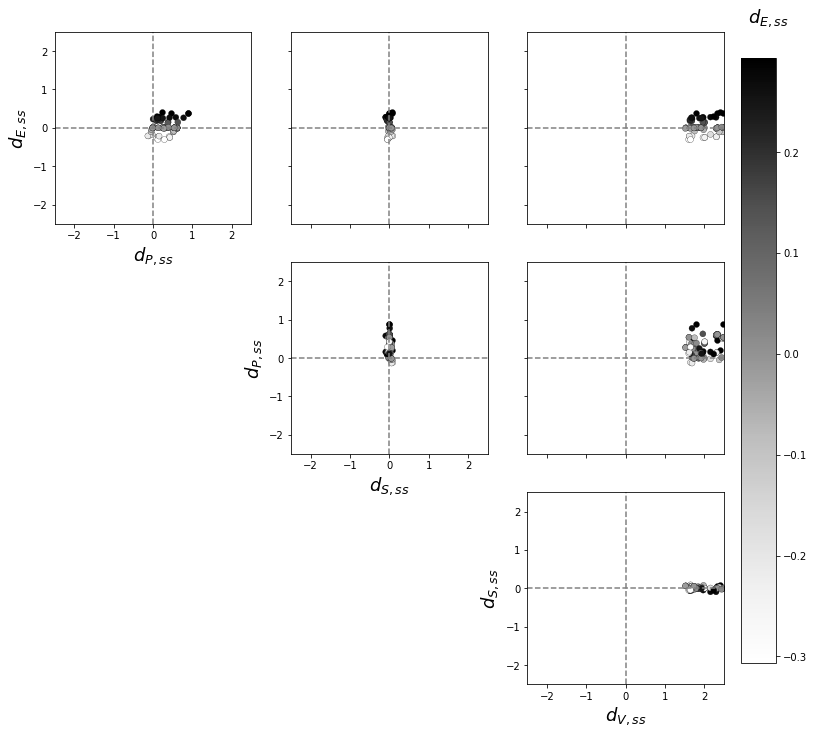

0.3015451415228803 0.24722565559958928


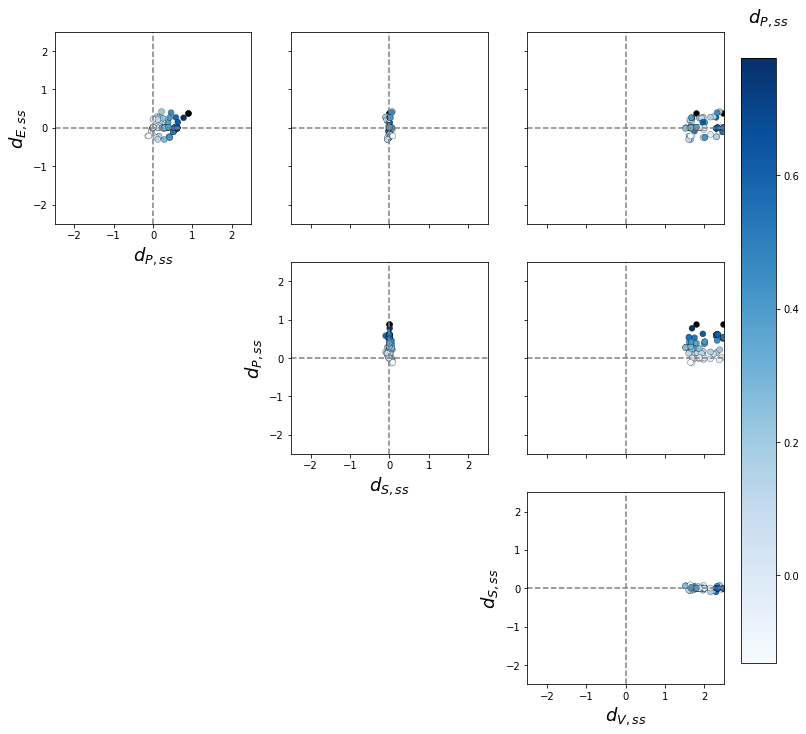

0.004847220531701022 0.03537358210907157


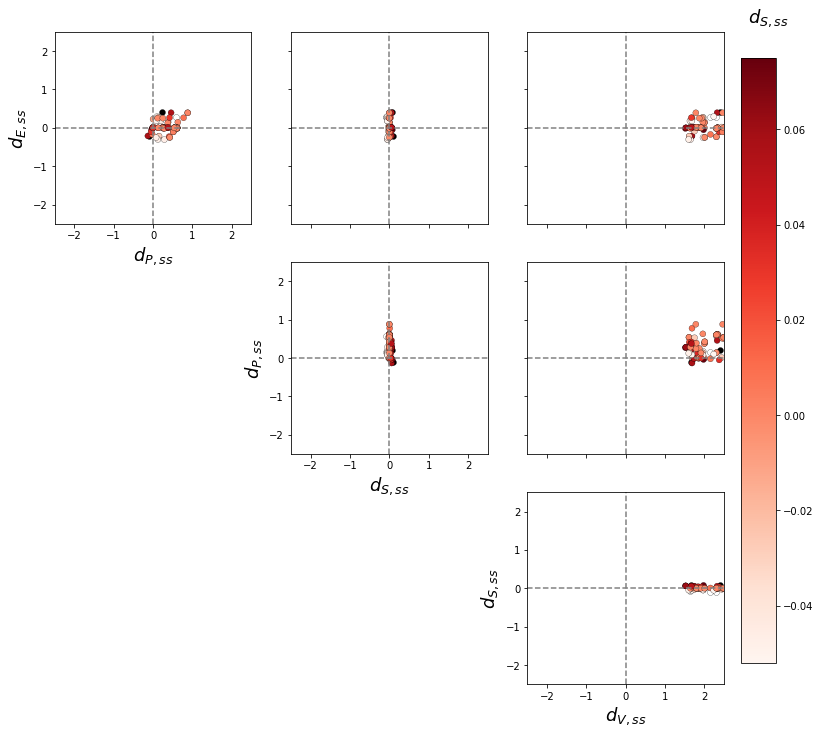

1.9658047203983 0.3048541324373596


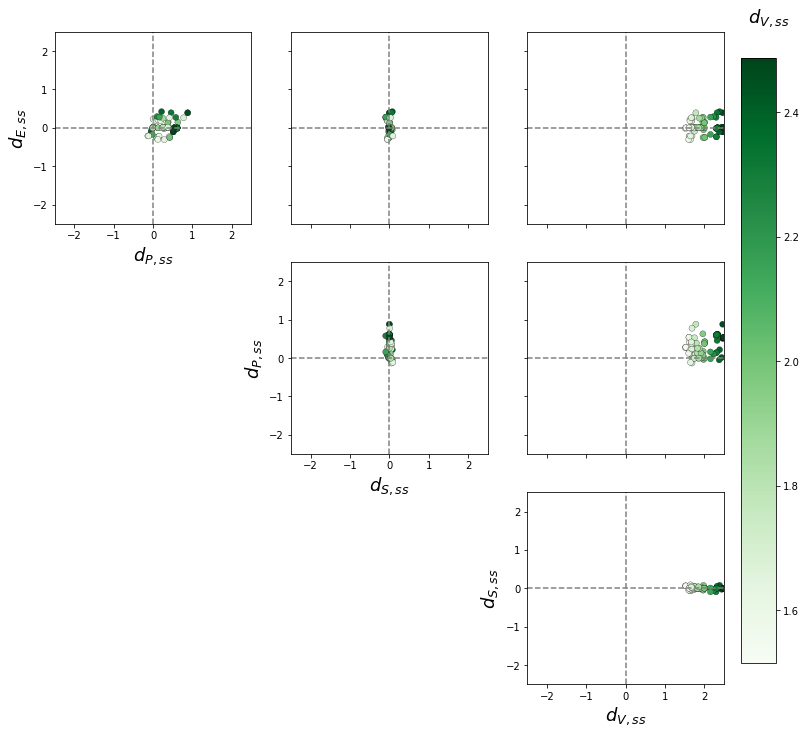

'\npdf = matplotlib.backends.backend_pdf.PdfPages("grid_samples_S_same_V_inc.pdf")\nfor fig in figs: ## will open an empty extra figure :(\n    pdf.savefig(fig)\npdf.close()\n'

In [18]:


figs = []

for color_ind in range(4):
    pfname = 'images/V1_grid_search_T_xs_tresh_%s.png' % cstrs[color_ind]
    fig = pairplot(_T_x[0, S_same_V_inc, :], range(4), system.T_x_labels, origin=True, \
                   c=_T_x[0,S_same_V_inc,color_ind], c_label=system.T_x_labels[color_ind], cmap=cmaps[color_ind], \
                   xlims=xlims, ylims=ylims, fontsize=18, \
                   figsize=(12,12), pfname=pfname)
    figs.append(fig)
    
"""
pdf = matplotlib.backends.backend_pdf.PdfPages("grid_samples_S_same_V_inc.pdf")
for fig in figs: ## will open an empty extra figure :(
    pdf.savefig(fig)
pdf.close()
"""

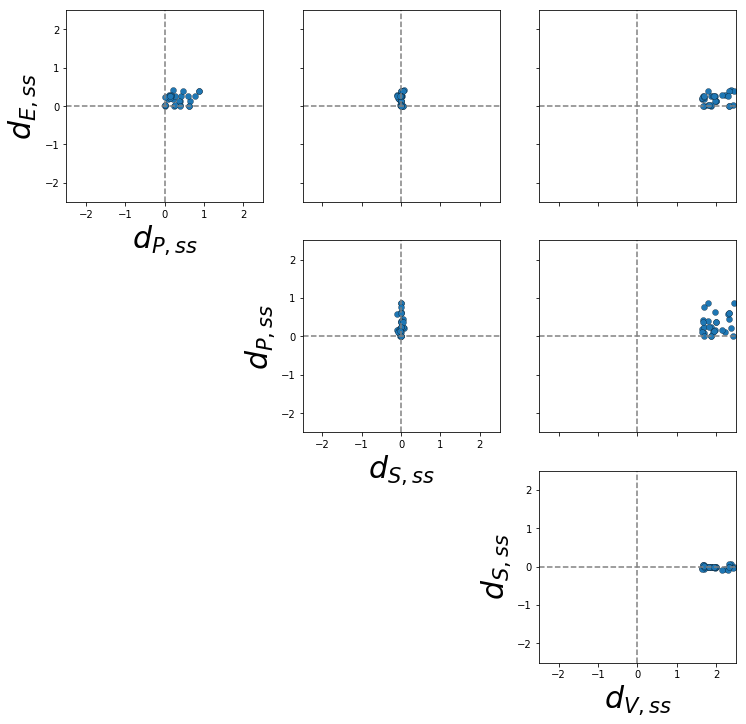

In [19]:
pfname = 'images/V1_grid_search_T_xs_thresh_all.png'
axlim = 2.5
xlims = [-axlim, axlim]
ylims = [-axlim, axlim]

E_inc = np.logical_and(0.0 < _T_x[0,:,0], _T_x[0,:,0] < 1.0);
P_inc = np.logical_and(0.0 < _T_x[0,:,1], _T_x[0,:,1] < 1.0);
E_inc_P_inc = np.logical_and(E_inc, P_inc);
inds = np.logical_and(E_inc_P_inc, S_same_V_inc)

fig = pairplot(_T_x[0,inds,:], range(4), system.T_x_labels, origin=True, \
               c=None, c_label=None, cmap=None, \
               xlims=xlims, ylims=ylims, fontsize=30, \
               figsize=(12,12), pfname=pfname)


(29, 8)


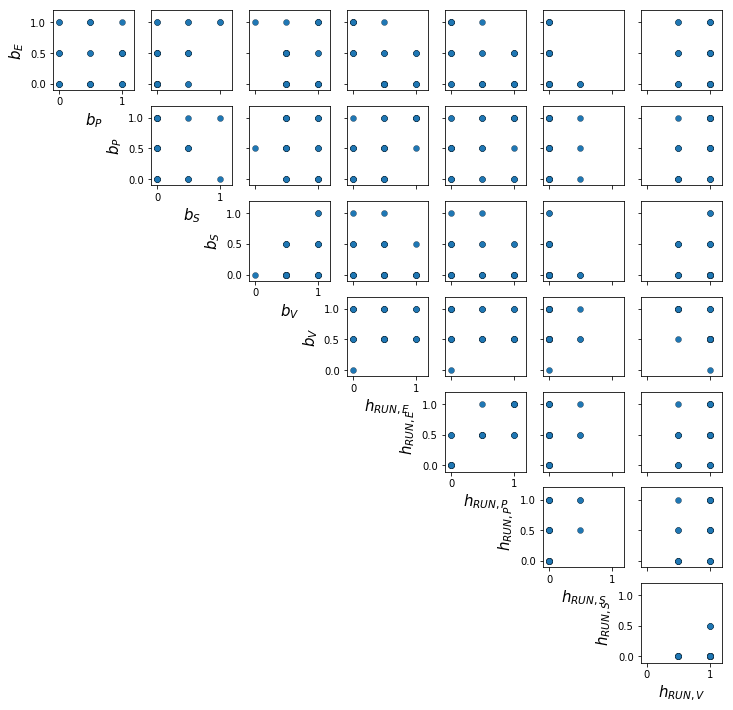

In [21]:
pfname = 'images/V1_grid_search_Z_thresh_all.png'
lims = [-.1, 1.2]
_Z_inds = _Z[0,inds, :]
jitter = np.random.normal(0.0, 0.00, _Z_inds.shape)
print(_Z_inds.shape)
_Z_inds = _Z_inds + jitter

fig = pairplot(_Z_inds, range(8), system.z_labels, origin=False, \
                   c=None, c_label=None, cmap=None, \
                   xlims=lims, ylims=lims, fontsize=15, \
                   figsize=(12,12), pfname=pfname)




0.02380605220007141 0.16633462020060447


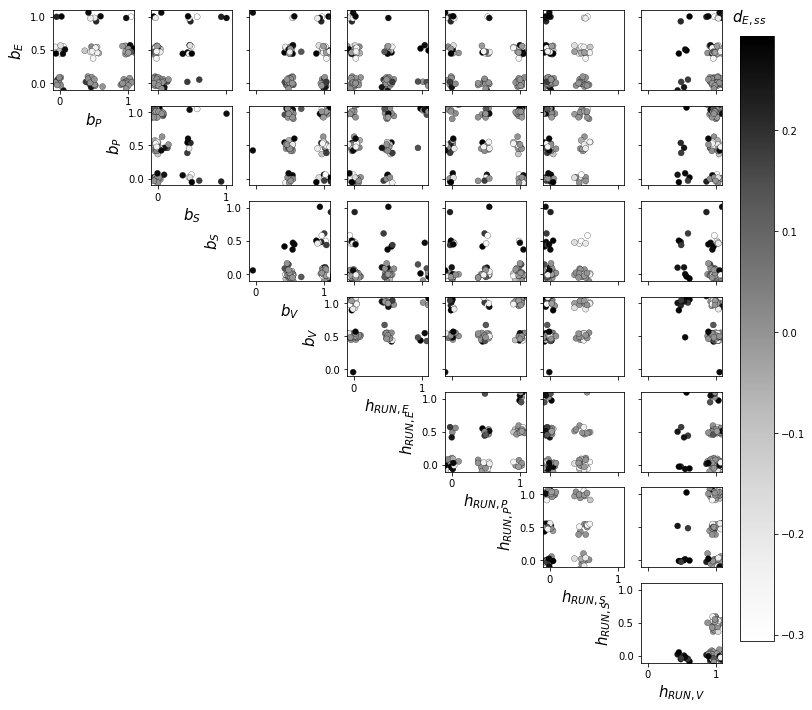

0.3015451415228803 0.24722565559958926


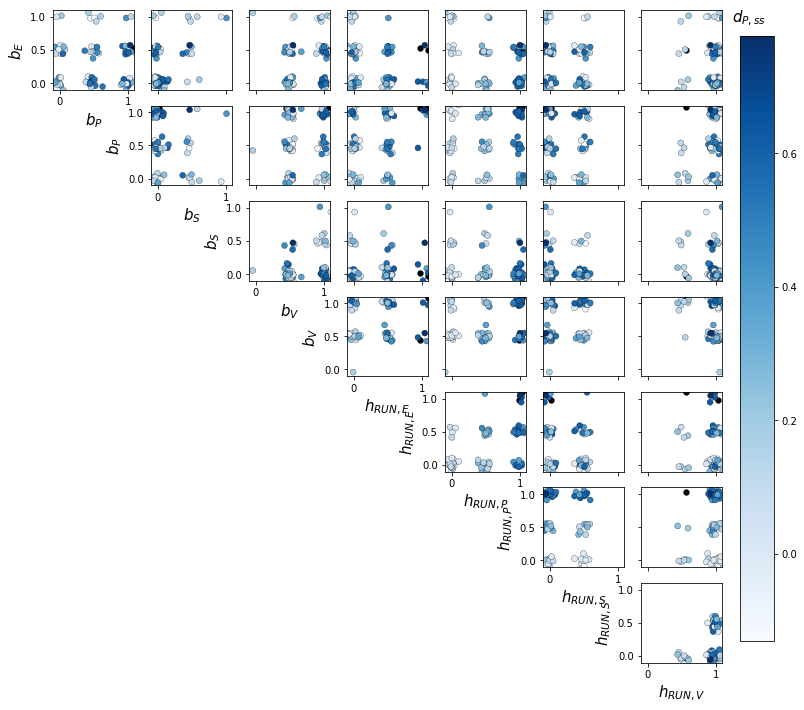

0.004847220531701021 0.03537358210907157


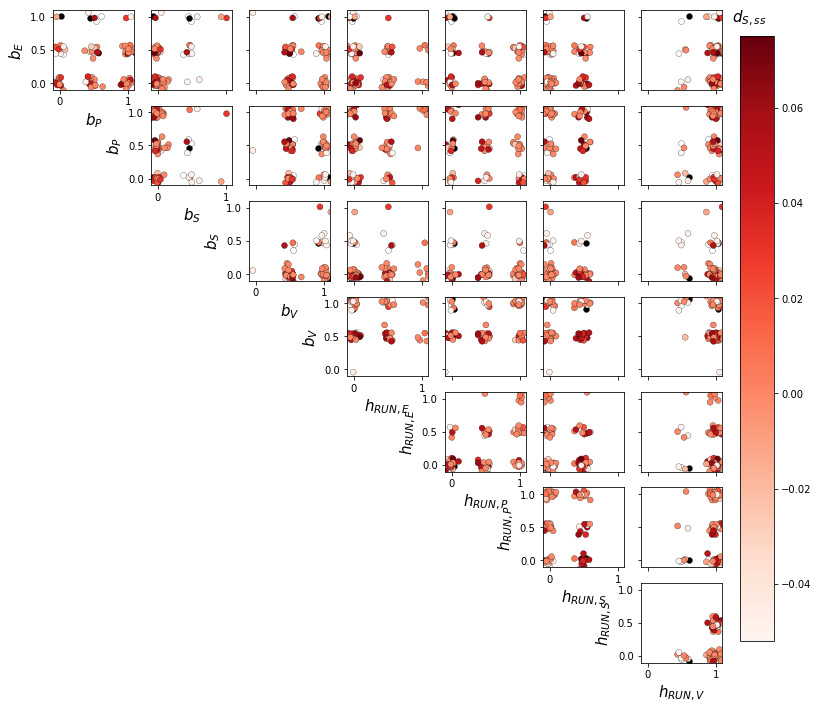

1.9658047203982996 0.3048541324373596


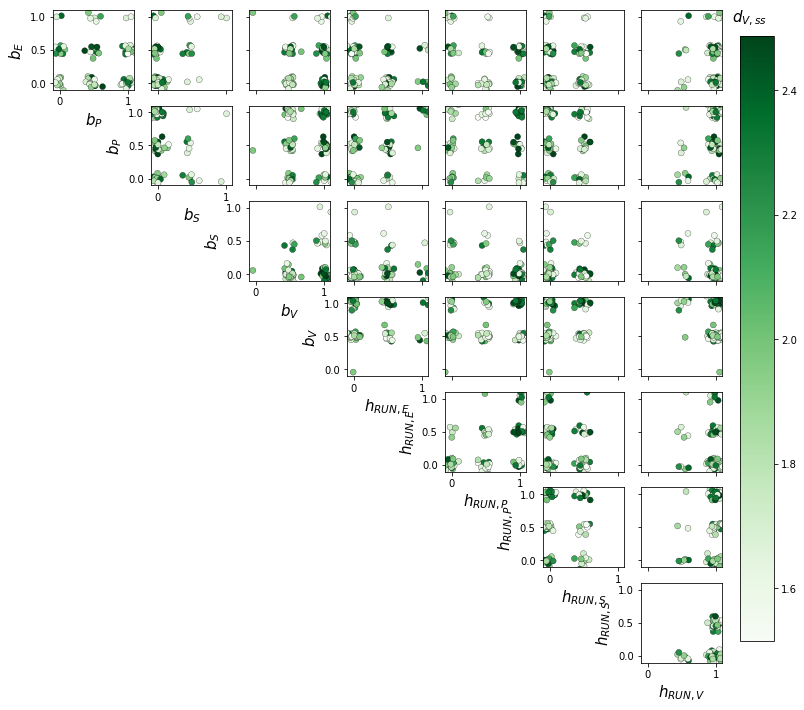

In [22]:
pfname = 'images/V1_grid_search_Z_thresh_%s.png' % cstrs[color_ind]
lims = [-.1, 1.1]
_Z_S_same_V_inc = _Z[0,S_same_V_inc, :]
jitter = np.random.normal(0.0, 0.05, _Z_S_same_V_inc.shape)
_Z_S_same_V_inc = _Z_S_same_V_inc + jitter
for color_ind in range(4):
    fig = pairplot(_Z_S_same_V_inc, range(8), system.z_labels, origin=False, \
                       c=_T_x[0,S_same_V_inc,color_ind], c_label=system.T_x_labels[color_ind], cmap=cmaps[color_ind], \
                       xlims=lims, ylims=lims, fontsize=15, \
                       figsize=(12,12), pfname=pfname)
    
    
    